










## Topic Modelling using Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA) in sklearn

### **There also exists implementation using the Gensim libray. Checkout the same [here](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)  ,   [here](https://nlpforhackers.io/topic-modeling/) and [here](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) and also in [this](https://github.com/susanli2016/NLP-with-Python/blob/master/LDA_news_headlines.ipynb) notebook.**

## [Please star/upvote in case u like it. ]

#### IMPORTING MODULES

In [1]:
import nltk
nltk.download('all',halt_on_error=False)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [ ]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
% matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

#preprocessing
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#stop-words
stop_words=set(nltk.corpus.stopwords.words('english'))

In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
··········


In [4]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


#### LOADING THE DATASET

In [ ]:
df=pd.read_csv('jurnal_terlabeli.xlsx')

In [6]:
df.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


We will drop the **'publish_date'** column as it is useless for our discussion.

In [ ]:
# drop the publish date.
df.drop(['publish_date'],axis=1,inplace=True)

In [8]:
df.head(10)

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers
5,ambitious olsson wins triple jump
6,antic delighted with record breaking barca
7,aussie qualifier stosur wastes four memphis match
8,aust addresses un security council over iraq
9,australia is locked into war timetable opp


#### DATA CLEANING & PRE-PROCESSING

Here I have done the data pre-processing. I have used the lemmatizer and can also use the stemmer. Also the stop words have been used along with the words wit lenght shorter than 3 characters to reduce some stray words.

In [ ]:
def clean_text(headline):
  le=WordNetLemmatizer()
  word_tokens=word_tokenize(headline)
  tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>3]
  cleaned_text=" ".join(tokens)
  return cleaned_text
  
  

In [ ]:
# time taking
df['headline_cleaned_text']=df['headline_text'].apply(clean_text)

In [11]:
df.head()

,headline_text,headline_cleaned_text
0,aba decides against community broadcasting lic...,decides community broadcasting licence
1,act fire witnesses must be aware of defamation,fire witness must aware defamation
2,a g calls for infrastructure protection summit,call infrastructure protection summit
3,air nz staff in aust strike for pay rise,staff aust strike rise
4,air nz strike to affect australian travellers,strike affect australian traveller


Can see the difference after removal of stopwords and some shorter words. aslo the words have been lemmatized as in **'calls'--->'call'.**

Now drop the unpre-processed column.

In [ ]:
df.drop(['headline_text'],axis=1,inplace=True)

In [15]:
df.head()

,headline_cleaned_text
0,decides community broadcasting licence
1,fire witness must aware defamation
2,call infrastructure protection summit
3,staff aust strike rise
4,strike affect australian traveller


We can also see any particular news headline.

In [17]:
df['headline_cleaned_text'][0]

'decides community broadcasting licence'

#### EXTRACTING THE FEATURES AND CREATING THE DOCUMENT-TERM-MATRIX ( DTM )

In DTM the values are the TFidf values.

Also I have specified some parameters of the Tfidf vectorizer.

Some important points:-

**1) LSA is generally implemented with Tfidf values everywhere and not with the Count Vectorizer.**

**2) max_features depends on your computing power and also on eval. metric (coherence score is a metric for topic model). Try the value that gives best eval. metric and doesn't limits processing power.**

**3) Default values for min_df & max_df worked well.**

**4) Can try different values for ngram_range.**

In [ ]:
vect =TfidfVectorizer(stop_words=stop_words,max_features=1000) # to play with. min_df,max_df,max_features etc...

In [ ]:
vect_text=vect.fit_transform(df['headline_cleaned_text'])

#### We can now see the most frequent and rare words in the news headlines based on idf score. The lesser the value; more common is the word in the news headlines.

In [21]:
print(vect_text.shape)
print(vect_text)

(1103665, 1000)
  (0, 178)	0.6247000549095533
  (0, 507)	0.7808648035325968
  (1, 320)	0.44224803605927093
  (1, 982)	0.6339199641322228
  (1, 575)	0.6344778590907005
  (2, 120)	0.5644371969796811
  (2, 683)	0.8254760145914118
  (3, 829)	0.5335839392638414
  (3, 52)	0.5181419180317365
  (3, 845)	0.4893827547760373
  (3, 745)	0.45532587436460414
  (4, 845)	0.7601376435177256
  (4, 54)	0.6497620817709503
  (5, 977)	0.6070768588163491
  (5, 472)	0.7946431195761244
  (6, 711)	1.0
  (7, 51)	0.4576558531379432
  (7, 960)	0.5395152091846916
  (7, 343)	0.48237669514032133
  (7, 543)	0.5165144558794856
  (8, 52)	0.46613929548695054
  (8, 12)	0.5263356683096936
  (8, 778)	0.4504550964714952
  (8, 200)	0.3477613388846276
  (8, 452)	0.42642370795717344
  :	:
  (1103656, 478)	0.5473775398163588
  (1103656, 626)	0.5843644384740314
  (1103657, 53)	0.34045218038840586
  (1103657, 967)	0.4180012338645188
  (1103657, 994)	0.35908839361701855
  (1103657, 816)	0.37947383343324353
  (1103657, 621)	0.424892

In [ ]:
idf=vect.idf_

In [23]:
dd=dict(zip(vect.get_feature_names(), idf))
l=sorted(dd, key=(dd).get)
# print(l)
print(l[0],l[-1])
print(dd['police'])
print(dd['forecast'])  # police is most common and forecast is least common among the news headlines.

police forecast
4.425126241429022
7.93966901278893


We can therefore see that on the basis of the **idf value** , **'police'** is the **most frequent** word while **'forecast'** is **least frequently** occuring among the news.

### TOPIC MODELLING

## Latent Semantic Analysis (LSA)

The first approach that I have used is the LSA. **LSA is basically singular value decomposition.**

**SVD decomposes the original DTM into three matrices S=U.(sigma).(V.T). Here the matrix U denotes the document-topic matrix while (V) is the topic-term matrix.**

**Each row of the matrix U(document-term matrix) is the vector representation of the corresponding document. The length of these vectors is the number of desired topics. Vector representation for the terms in our data can be found in the matrix V (term-topic matrix).**

So, SVD gives us vectors for every document and term in our data. The length of each vector would be k. **We can then use these vectors to find similar words and similar documents using the cosine similarity method.**

We can use the truncatedSVD function to implement LSA. The n_components parameter is the number of topics we wish to extract.
The model is then fit and transformed on the result given by vectorizer. 

**Lastly note that LSA and LSI (I for indexing) are the same and the later is just sometimes used in information retrieval contexts.**

In [ ]:
from sklearn.decomposition import TruncatedSVD
lsa_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10, random_state=42)

lsa_top=lsa_model.fit_transform(vect_text)


In [25]:
print(lsa_top)
print(lsa_top.shape)  # (no_of_doc*no_of_topics)

[[ 9.89643903e-05  9.76452288e-03  2.38617397e-02 ... -4.40176615e-04
  -2.22968585e-03 -1.10392576e-03]
 [ 5.45388946e-04  5.11340198e-02  8.12565274e-02 ... -4.19252853e-02
   2.33818602e-02  6.48656535e-03]
 [ 5.39530192e-04  4.83438453e-02  1.48684664e-01 ... -8.30586373e-02
   1.02704844e-02 -3.90544521e-02]
 ...
 [ 3.45696762e-04  2.02376611e-02  9.27628985e-02 ...  5.20374240e-01
   5.87045135e-02 -8.34028575e-02]
 [ 5.77834566e-05  4.97264849e-03  1.65807048e-02 ... -7.67979722e-05
   7.19948822e-03 -6.67442689e-04]
 [ 8.68754686e-04  1.39626405e-02  2.82763784e-02 ...  8.37960027e-04
  -1.05045259e-03  5.09194053e-03]]
(1103665, 10)


In [26]:
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
  print("Topic ",i," : ",topic*100)
  


Document 0 :
Topic  0  :  0.009896439034555452
Topic  1  :  0.9764522883194123
Topic  2  :  2.386173965574605
Topic  3  :  -0.759927151770875
Topic  4  :  -0.27595598855522085
Topic  5  :  -0.028531466086884907
Topic  6  :  0.017571227492954655
Topic  7  :  -0.04401766153892579
Topic  8  :  -0.22296858475290793
Topic  9  :  -0.11039257585876291


Similalry for other documents we can do this. However note that values dont add to 1 as in LSA it is not probabiltiy of a topic in a document.

In [27]:
print(lsa_model.components_.shape) # (no_of_topics*no_of_words)
print(lsa_model.components_)

(10, 1000)
[[ 1.56233935e-05  2.21523405e-05  5.50927063e-05 ...  5.20561278e-05
   2.94023425e-05  3.43601982e-05]
 [ 7.96827775e-04  1.13734036e-03  1.29070311e-03 ...  1.73307863e-03
   2.37784007e-03  2.69935362e-03]
 [ 2.43201192e-03  3.62603949e-03  4.08238815e-03 ...  4.37127625e-03
   4.61909874e-03  5.70998743e-03]
 ...
 [ 2.10135463e-03  2.46245697e-03  4.07951302e-03 ...  1.42896678e-02
   2.05543135e-03  2.10956263e-04]
 [-4.68144581e-05 -8.32570486e-06  2.26145119e-04 ...  1.04824847e-03
  -8.17000276e-04 -2.03393998e-04]
 [ 4.84078065e-05 -2.78633263e-04 -4.28111287e-04 ... -1.66730815e-03
   3.25036932e-05  3.35209959e-05]]


#### Now e can get a list of the important words for eah of the 10 topics as shown. For simplicity here I have shown 10 words for each topic.

In [28]:
# most important words for each topic
vocab = vect.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")
         

Topic 0: 
interview extended michael john david smith james andrew mark police 

Topic 1: 
police death probe fire woman crash call court missing say 

Topic 2: 
say plan council call govt back fire australia court water 

Topic 3: 
say australia police need minister report must could expert wont 

Topic 4: 
court fire face woman murder charged charge accused death australia 

Topic 5: 
call medium australia say inquiry prompt report spark change death 

Topic 6: 
fire house home say crew govt blaze damage threat warning 

Topic 7: 
australia back world south first test australian take win india 

Topic 8: 
council australia crash fire year death rate charged rise dy 

Topic 9: 
back council report fight market hit business police push news 



## Latent Dirichlet Allocation (LDA)  

LDA is the most popular technique.**The topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.**

**To understand the maths it seems as if knowledge of Dirichlet distribution (distribution of distributions) is required which is quite intricate and left fior now.**

To get an inituitive explanation of LDA checkout these blogs: [this](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)  ,  [this](https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/)  ,[this](https://en.wikipedia.org/wiki/Topic_model)  ,  [this kernel on Kaggle](https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial)  ,  [this](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/) and also [this](https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda) kernel on same dataset.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1) 
# n_components is the number of topics

In [ ]:
lda_top=lda_model.fit_transform(vect_text)

In [32]:
print(lda_top.shape)  # (no_of_doc,no_of_topics)
print(lda_top)


(1103665, 10)
[[0.04157028 0.04157028 0.04157028 ... 0.36617794 0.30125984 0.04157028]
 [0.03689158 0.03689158 0.03689158 ... 0.03689158 0.03689158 0.03689158]
 [0.04184252 0.04184252 0.04184252 ... 0.04184252 0.04184252 0.04184252]
 ...
 [0.04178881 0.04178881 0.04178881 ... 0.04178881 0.04178881 0.04178881]
 [0.05       0.55       0.05       ... 0.05       0.05       0.05      ]
 [0.03663108 0.03663108 0.03663108 ... 0.2351103  0.03663108 0.03663108]]


In [33]:
sum=0
for i in lda_top[0]:
  sum=sum+i
print(sum)  

1.0


#### Note that the values in a particular row adds to 1. This is beacuse each value denotes the % of contribution of the corressponding topic in the document.

In [34]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(lda_top[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  4.157027803770169 %
Topic  1 :  4.157027803820645 %
Topic  2 :  4.157027803777354 %
Topic  3 :  4.157027803776605 %
Topic  4 :  4.157027803774463 %
Topic  5 :  4.1570278037953035 %
Topic  6 :  4.157027803758549 %
Topic  7 :  36.61779356195755 %
Topic  8 :  30.12598400778941 %
Topic  9 :  4.157027803779964 %


#### As we can see Topic 7 & 8 are dominantly present in document 0.

 

In [36]:
print(lda_model.components_)
print(lda_model.components_.shape)  # (no_of_topics*no_of_words)

[[1.00001665e-01 1.00002942e-01 1.00007231e-01 ... 1.00006131e-01
  1.00006996e-01 6.77778584e+02]
 [1.00000392e-01 1.00000800e-01 1.00002321e-01 ... 1.00003801e-01
  1.00006091e-01 1.00002668e-01]
 [1.00003627e-01 1.00003488e-01 1.00009398e-01 ... 1.00004354e-01
  1.00006168e-01 1.00004684e-01]
 ...
 [1.00002421e-01 1.00001269e-01 1.00003430e-01 ... 1.00003117e-01
  1.00010235e-01 1.00003309e-01]
 [3.05380770e+02 1.00001626e-01 1.00005187e-01 ... 1.80763591e+03
  4.74531077e+02 1.00006340e-01]
 [1.00002784e-01 1.00000990e-01 1.00003103e-01 ... 1.00004151e-01
  1.00007408e-01 1.00001753e-01]]
(10, 1000)


#### Most important words for a topic. (say 10 this time.)

In [38]:
# most important words for each topic
vocab = vect.get_feature_names()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
police world death first show country take house record john 

Topic 1: 
plan final council power water farmer shooting young port industry 

Topic 2: 
woman north school could coast tasmania open tasmanian west accused 

Topic 3: 
trump say melbourne canberra south state change win city bill 

Topic 4: 
australian year home back crash indigenous rural health labor high 

Topic 5: 
australia interview report time island dead claim deal refugee leader 

Topic 6: 
government sydney queensland call fire perth brisbane market turnbull test 

Topic 7: 
adelaide child court donald murder charged dy hospital former face 

Topic 8: 
election people 2016 drug help victoria community find missing fight 

Topic 9: 
attack family life found china live darwin business drum liberal 



#### To better visualize words in a topic we can see the word cloud. For each topic top 50 words are plotted.

In [ ]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):
  imp_words_topic=""
  comp=lda_model.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()
 

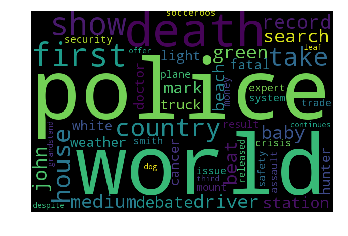

In [40]:
# topic 0
draw_word_cloud(0)

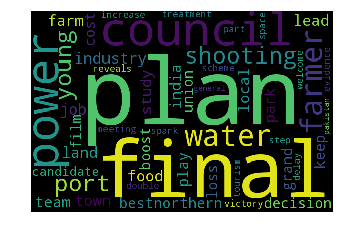

In [41]:
# topic 1
draw_word_cloud(1)  # ...

## THE END !!!

## [Please star/upvote in case u liked it. ]